In [14]:
%matplotlib inline

import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np

import matplotlib.pylab as plt

from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

In [2]:
def get_order(order_file):
    order = pd.read_csv(order_file,  
                        parse_dates=True)
    order.set_index("date", inplace=True)
    return order

def get_closing_price(ticker, start, end):
    s = pdr.get_data_google(ticker, 
                            start, 
                            end)["Close"]
    return s

In [3]:
def portfolio_simulation(order_file, start, end, initial_captital=0):
    stocks = []
    order_list = get_order(order_file)
    # compute the volume
    order_list["vol"] = order_list.apply(lambda row: row["vol"] if row["command"] == "BUY" else -row["vol"] , axis=1)
    order_list = order_list.groupby(["date", "ticker"]).sum()
    order_list.reset_index(inplace=True)
    order_list.set_index(["date"], inplace=True)
    
    # extrat the ticker list
    tickers_list = set(order_list["ticker"].values)
    
    for ticker in tickers_list:
        # get the closing price of a given equity
        closing_price = get_closing_price(ticker, start, end)
        
        # get the vol of a given equity
        order = order_list[order_list["ticker"] == ticker]["vol"]
        
        # concat and align the closing price and the order volume
        equity = pd.concat(closing_price.align(order, fill_value=0), axis=1)
        equity.columns = [ticker, ticker+'_vol']
        stocks.append(equity)

    # concat all
    df = pd.concat(stocks, axis=1)

    for ticker in tickers_list:
        df[ticker+"_cumvol"] = df[ticker+"_vol"].cumsum()
        df[ticker+"_value"] = df[ticker] * df[ticker+"_cumvol"]
        df[ticker+"_order"] = df[ticker+"_vol"] * df[ticker]

    df["portfolio_value"] = df.filter(regex="value").sum(axis=1)
    df["order_value"] = df.filter(regex="order").sum(axis=1)
    
    # compute the capital
    df["capital"] = 0
    for i,row in df.iterrows():
        initial_captital -= row["order_value"]
        df.loc[i, "capital"] = initial_captital

    return df

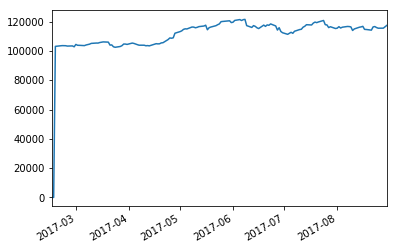

In [4]:
start = "2017-02-15"
end = "2017-08-30"
order_file = "order.csv"
capital = 100000

df = portfolio_simulation(order_file, start, end, capital)
df["portfolio_value"].plot()

In [15]:
TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(x_axis_type="datetime", title="Portfolio value", plot_width=600, plot_height=450, tools=TOOLS)

p.line(df.index, df["portfolio_value"], color='blue', legend='portfolio')
p.line(df.index, df['capital'], color='red', legend='capital')
p.line(df.index, df['capital']+df['portfolio_value'], color='green', legend='portfolio + capital')

p.ygrid.band_fill_color = "olive"
p.ygrid.band_fill_alpha = 0.1
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Price in $'

t = show(p, notebook_handle=True)